In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/fuzzy_dataset'

In [ ]:
#pip install split-folders

In [ ]:
# import splitfolders

# splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/fuzzy_dataset", # The location of dataset
#                   output="/content/drive/MyDrive/Colab Notebooks/fuzzy_split_data", # The output location
#                   ratio=(.8, .1, .1), # The ratio of splited dataset
#                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                   move=False, # If you choose to move, turn this into True
#                   seed=42
#                   )

In [ ]:
import os 
import cv2
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet101V2
from keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras import optimizers

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/fuzzy_color_split_data/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/fuzzy_color_split_data/test'
val_path = '/content/drive/MyDrive/Colab Notebooks/fuzzy_color_split_data/val'

In [ ]:
labels = os.listdir(train_path)
print(labels)

['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']


In [ ]:
train_n_path = train_path+'/Normal/'
train_c_path = train_path+'/COVID/'
train_l_path = train_path+'/Lung_Opacity'
train_v_path = train_path+'/Viral Pneumonia/'

test_n_path = test_path+'/Normal/'
test_c_path = test_path+'/COVID/'
test_l_path = test_path+'/Lung_Opacity'
test_v_path = test_path+'/Viral Pneumonia/'

val_n_path = val_path+'/Normal/'
val_c_path = val_path+'/COVID/'
val_l_path = val_path+'/Lung_Opacity'
val_v_path = val_path+'/Viral Pneumonia/'

In [ ]:
print(f'Number of normal images is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of covid images is {len(os.listdir(train_c_path))}') #length of COVID training images 
print(f'Number of lung_opacity images is {len(os.listdir(train_l_path))}') #length of lung_opacity training images 
print(f'Number of pneumonia images is {len(os.listdir(train_v_path))}') #length of pneumonia training images 
print(f'Total training images is  {len(os.listdir(train_n_path)) + len(os.listdir(train_c_path)) + len(os.listdir(train_l_path)) + len(os.listdir(train_v_path))}')

Number of normal images is 8153
Number of covid images is 2892
Number of lung_opacity images is 4809
Number of pneumonia images is 1076
Total training images is  16930


In [ ]:
print(f'Number of normal images is {len(os.listdir(test_n_path))}') #length of normal test images
print(f'Number of covid images is {len(os.listdir(test_c_path))}') #length of COVID test images 
print(f'Number of lung_opacity images is {len(os.listdir(test_l_path))}') #length of lung_opacity test images 
print(f'Number of pneumonia images is {len(os.listdir(test_v_path))}') #length of pneumonia test images 
print(f'Total testing images is  {len(os.listdir(test_n_path)) + len(os.listdir(test_c_path)) + len(os.listdir(test_l_path)) + len(os.listdir(test_v_path))}')

Number of normal images is 1020
Number of covid images is 363
Number of lung_opacity images is 602
Number of pneumonia images is 135
Total testing images is  2120


In [ ]:
print(f'Number of normal images is {len(os.listdir(val_n_path))}') #length of normal val images
print(f'Number of covid images is {len(os.listdir(val_c_path))}') #length of COVID val images 
print(f'Number of lung_opacity images is {len(os.listdir(val_l_path))}') #length of lung_opacity val images 
print(f'Number of pneumonia images is {len(os.listdir(val_v_path))}') #length of pneumonia val images 
print(f'Total testing images is  {len(os.listdir(val_n_path)) + len(os.listdir(val_c_path)) + len(os.listdir(val_l_path)) + len(os.listdir(val_v_path))}')

Number of normal images is 1019
Number of covid images is 361
Number of lung_opacity images is 601
Number of pneumonia images is 134
Total testing images is  2115


In [ ]:
img_size = 224

In [ ]:
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data(train_path)
test = get_training_data(test_path)
val = get_training_data(val_path)

<ipython-input-12-226148560195>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = 0.2,  
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    horizontal_flip = True, 
)

In [ ]:
train_datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 4, activation = 'softmax'))

model.compile(
              optimizer = 'adam', loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
train_n_path = train_path+'/Normal/'
train_c_path = train_path+'/COVID/'
train_l_path = train_path+'/Lung_Opacity'
train_v_path = train_path+'/Viral Pneumonia/'

total = len(os.listdir(train_n_path)) + len(os.listdir(train_c_path)) + len(os.listdir(train_l_path)) + len(os.listdir(train_v_path))

covid = len(os.listdir(train_c_path))
normal = len(os.listdir(train_n_path))
viral = len(os.listdir(train_v_path))
lung_opacity = len(os.listdir(train_l_path))


weight_for_c = 1/covid * (total/4.0)
weight_for_n = 1/normal * (total/4.0)
weight_for_v = 1/viral * (total/4.0)
weight_for_l = 1/lung_opacity * (total/4.0)

class_weight = {0:weight_for_c, 1:weight_for_n, 2:weight_for_v, 3:weight_for_l}
class_weight

{0: 1.4635200553250347,
 1: 0.5191340610818104,
 2: 3.9335501858736057,
 3: 0.880120607194843}

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [ ]:
import keras.utils as ku


y_train = ku.to_categorical(y_train, 4)
y_test = ku.to_categorical(y_test, 4)
y_val = ku.to_categorical(y_val, 4)

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/fuzzy_baseline.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]
history = model.fit(train_datagen.flow(x_train, y_train, batch_size = 32), 
                    epochs = 25, validation_data = train_datagen.flow(x_val, y_val), 
                    callbacks = callbacks, class_weight = class_weight)

Epoch 1/25
530/530 [==============================] - 189s 331ms/step - loss: 1.3246 - accuracy: 0.5336 - val_loss: 1.5980 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - 179s 338ms/step - loss: 0.9108 - accuracy: 0.6167 - val_loss: 3.8806 - val_accuracy: 0.2785 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.8414 - accuracy: 0.6383
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
530/530 [==============================] - 179s 339ms/step - loss: 0.8414 - accuracy: 0.6383 - val_loss: 4.2638 - val_accuracy: 0.0894 - lr: 0.0010
Epoch 4/25
530/530 [==============================] - 179s 338ms/step - loss: 0.7220 - accuracy: 0.6722 - val_loss: 1.1757 - val_accuracy: 0.5286 - lr: 3.0000e-04
Epoch 5/25
530/530 [==============================] - 179s 337ms/step - loss: 0.6414 - accuracy: 0.7102 - val_loss: 1.0596 - val_accuracy: 0.6454 - lr: 3.0000e-04
Epoch 6/25
530/530 [================

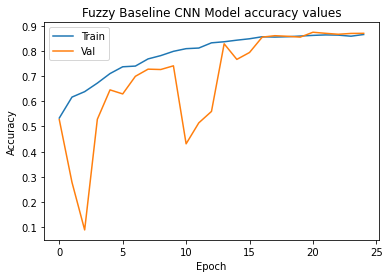

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Stacked Baseline CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

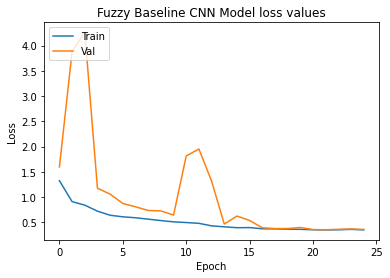

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stacked Baseline CNN Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 1s 8ms/step


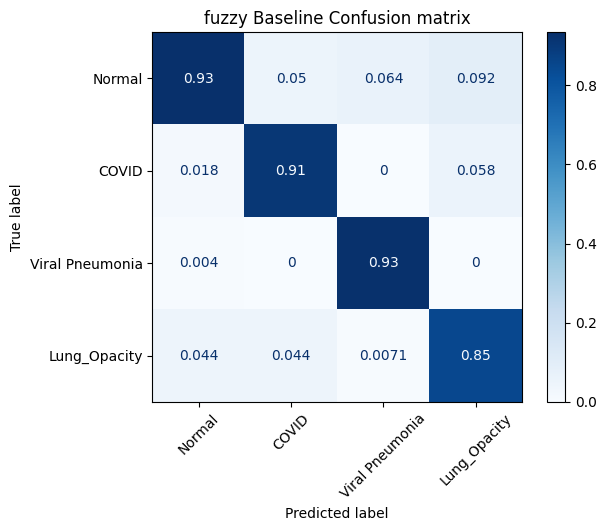

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fuzzy_baseline.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('fuzzy Baseline Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

         Normal       0.93      0.92      0.93      1020
          COVID       0.91      0.85      0.88       363
Viral Pneumonia       0.93      0.97      0.95       135
   Lung_Opacity       0.85      0.90      0.87       602

       accuracy                           0.90      2120
      macro avg       0.90      0.91      0.91      2120
   weighted avg       0.90      0.90      0.90      2120



VGG16 Fuzzy




In [ ]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_1.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history=vgg_model.fit(
  train_datagen.flow(x_train, y_train, batch_size = 32), epochs = 25, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight, callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.7747 - accuracy: 0.7053
Epoch 1: val_loss improved from inf to 0.64183, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_1.h5
530/530 [==============================] - 181s 338ms/step - loss: 0.7747 - accuracy: 0.7053 - val_loss: 0.6418 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.7620
Epoch 2: val_loss improved from 0.64183 to 0.58156, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_1.h5
530/530 [==============================] - 181s 341ms/step - loss: 0.6253 - accuracy: 0.7620 - val_loss: 0.5816 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7741
Epoch 3: val_loss did not improve from 0.58156
530/530 [==============================] - 179s 338ms/step - loss: 0.6053 - accuracy: 0.7741 - val_loss: 0.8993 - val

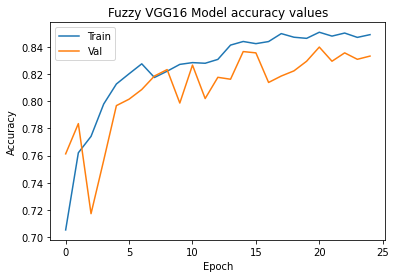

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Stacked VGG16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

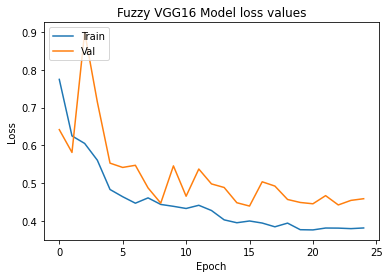

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Stacked VGG16 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 2s 21ms/step


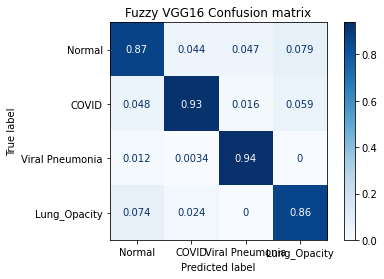

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_1.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked VGG16 Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

         Normal       0.87      0.94      0.90      1020
          COVID       0.93      0.75      0.83       363
Viral Pneumonia       0.94      0.90      0.92       135
   Lung_Opacity       0.86      0.85      0.86       602

       accuracy                           0.88      2120
      macro avg       0.90      0.86      0.88      2120
   weighted avg       0.88      0.88      0.88      2120



VGG16 Fuzzy Fine Tuning

In [ ]:
IMAGE_SIZE = [224, 224]
vgg_trainable = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg_trainable.trainable = True

# Retrain the last 3 layers (all lower layers will be kept frozen)
for layer in vgg_trainable.layers[:-3]:
    layer.trainable = False

x_trainable = Flatten()(vgg_trainable.output)
prediction = Dense(4, activation='softmax')(x_trainable)
model_trainable = Model(inputs=vgg_trainable.input, outputs=prediction)
model_trainable.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_trainable.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history=model_trainable.fit(
  train_datagen.flow(x_train, y_train, batch_size = 32), epochs = 25, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight, callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.6690
Epoch 1: val_loss improved from inf to 0.74507, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_2.h5
530/530 [==============================] - 180s 338ms/step - loss: 0.8410 - accuracy: 0.6690 - val_loss: 0.7451 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.7490
Epoch 2: val_loss improved from 0.74507 to 0.65898, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_2.h5
530/530 [==============================] - 179s 338ms/step - loss: 0.6245 - accuracy: 0.7490 - val_loss: 0.6590 - val_accuracy: 0.7527 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.7758
Epoch 3: val_loss improved from 0.65898 to 0.60101, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_2.h5
530/530 [===========================

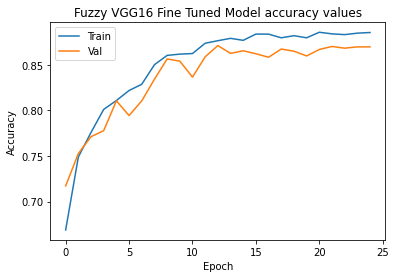

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Stacked VGG16 Fine Tuned Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

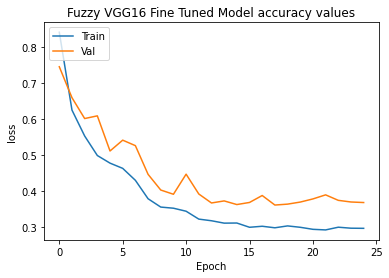

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Stacked VGG16 Fine Tuned Model accuracy values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 1s 17ms/step


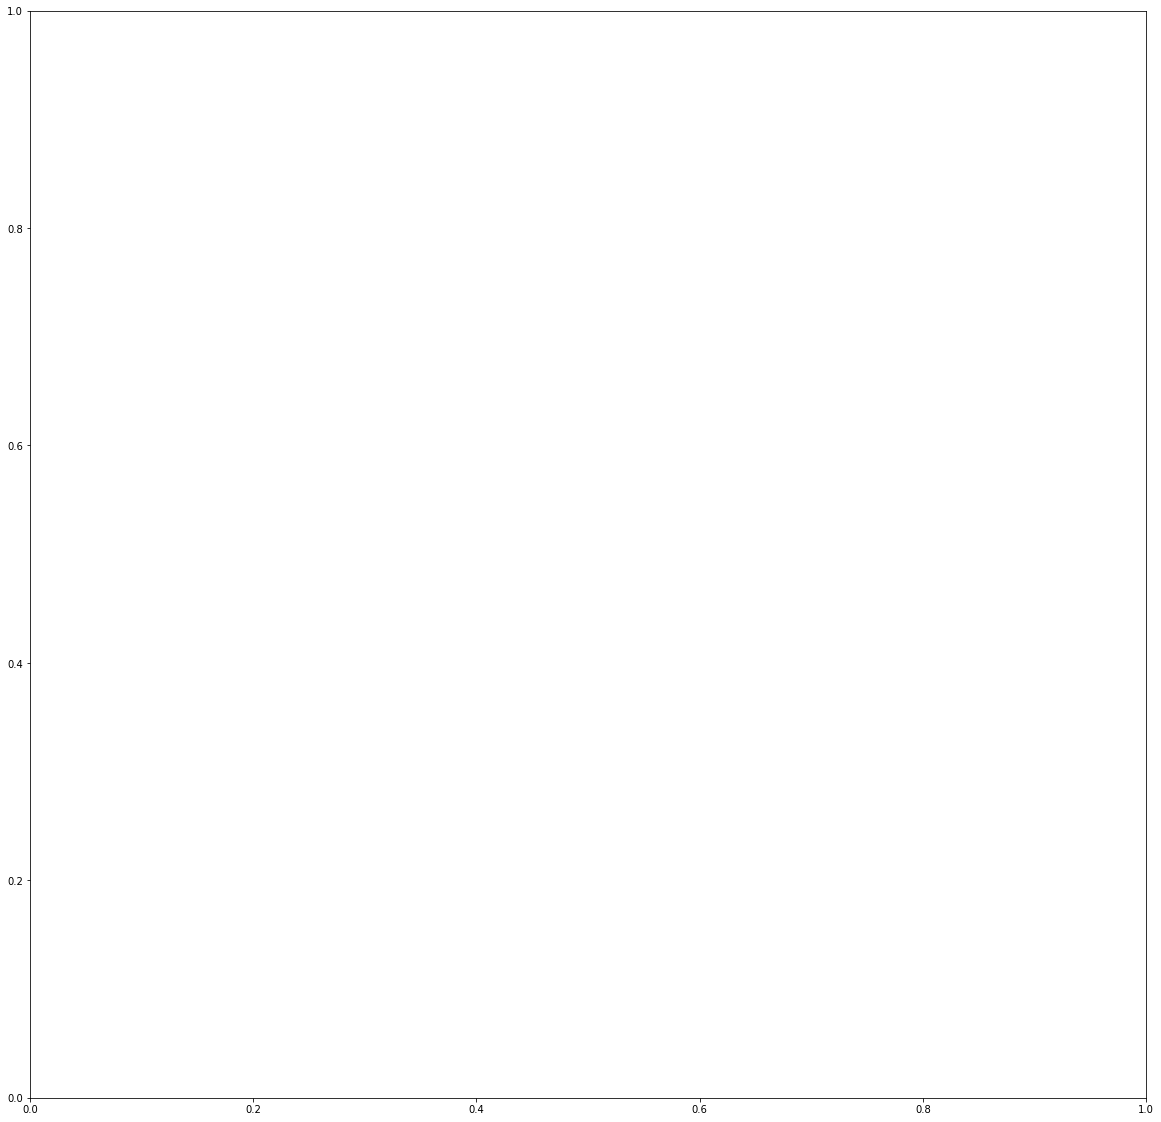

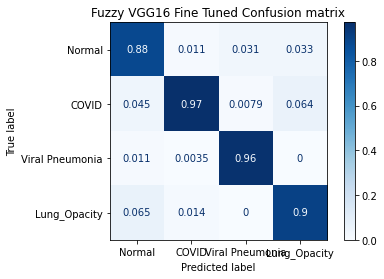

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fuzzy_vgg_model_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('fuzzy VGG16 Fine Tuned Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 2s 19ms/step - loss: 0.2844 - accuracy: 0.9028
Test loss: 0.2844030261039734
Test accuracy: 0.902830183506012


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

         Normal       0.88      0.97      0.92      1020
          COVID       0.97      0.75      0.85       363
Viral Pneumonia       0.96      0.90      0.93       135
   Lung_Opacity       0.90      0.87      0.89       602

       accuracy                           0.90      2120
      macro avg       0.93      0.88      0.90      2120
   weighted avg       0.91      0.90      0.90      2120



Resnet101 Fuzzy Model

In [ ]:
base_model = ResNet101V2(input_shape = [224, 224, 3] ,weights='imagenet', include_top=False)
num_classes = 4
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
resnet_model = Model(inputs=base_model.input, outputs=prediction)
resnet_model.summary()

171317808/171317808 [==============================] - 8s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [ ]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_1.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history_resnet=resnet_model.fit(
  train_datagen.flow(x_train, y_train),
  validation_data=train_datagen.flow(x_val, y_val),
  epochs=25,
  callbacks = callbacks,
  class_weight = class_weight,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 3.8456 - accuracy: 0.7483
Epoch 1: val_loss improved from inf to 3.87248, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_1.h5
530/530 [==============================] - 190s 347ms/step - loss: 3.8456 - accuracy: 0.7483 - val_loss: 3.8725 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 4.4626 - accuracy: 0.7851
Epoch 2: val_loss did not improve from 3.87248
530/530 [==============================] - 183s 345ms/step - loss: 4.4626 - accuracy: 0.7851 - val_loss: 4.3083 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 4.4921 - accuracy: 0.8031
Epoch 3: val_loss did not improve from 3.87248
530/530 [==============================] - 181s 341ms/step - loss: 4.4921 - accuracy: 0.8031 - val_loss: 5.1529 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 4/25
530/530 [===========================

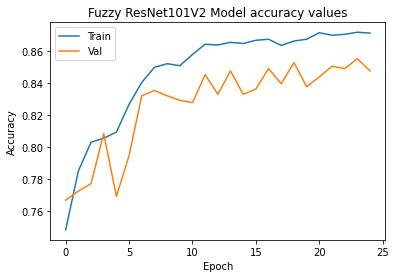

In [ ]:
plt.plot(model_history_resnet.history['accuracy'])
plt.plot(model_history_resnet.history['val_accuracy'])
plt.title('Stacked ResNet101V2 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

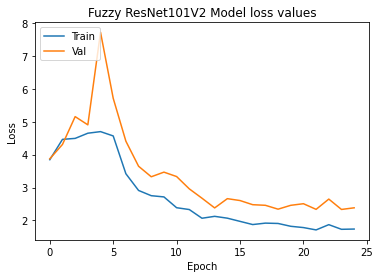

In [ ]:
plt.plot(model_history_resnet.history['loss'])
plt.plot(model_history_resnet.history['val_loss'])
plt.title('Stacked ResNet101V2 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 3s 28ms/step


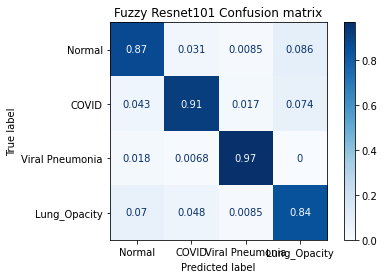

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_1.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)

result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked Resnet101 Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_1.h5')
score = test_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 4s 31ms/step - loss: 2.2256 - accuracy: 0.8726
Test loss: 2.225597620010376
Test accuracy: 0.8726415038108826


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

         Normal       0.87      0.94      0.90      1020
          COVID       0.91      0.74      0.82       363
Viral Pneumonia       0.97      0.84      0.90       135
   Lung_Opacity       0.84      0.85      0.84       602

       accuracy                           0.87      2120
      macro avg       0.90      0.84      0.87      2120
   weighted avg       0.88      0.87      0.87      2120



Resnet101 Fuzzy Model Finetuning

In [ ]:
res_trainable = ResNet101V2(input_shape = [224, 224, 3] ,weights='imagenet', include_top=False)
num_classes = 4
res_trainable.trainable = True
for layer in res_trainable.layers[:-10]:
    layer.trainable = False
x = Flatten()(res_trainable.output)
prediction = Dense(num_classes, activation='softmax')(x)
fine_resnet_model = Model(inputs=res_trainable.input, outputs=prediction)
fine_resnet_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
fine_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history_fine_resnet=fine_resnet_model.fit(
  train_datagen.flow(x_train, y_train),
  validation_data=train_datagen.flow(x_val, y_val),
  epochs=25,
  callbacks = callbacks,
  class_weight = class_weight,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.7526
Epoch 1: val_loss improved from inf to 0.69093, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_2.h5
530/530 [==============================] - 191s 347ms/step - loss: 0.8033 - accuracy: 0.7526 - val_loss: 0.6909 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.8073
Epoch 2: val_loss did not improve from 0.69093
530/530 [==============================] - 181s 342ms/step - loss: 0.5172 - accuracy: 0.8073 - val_loss: 1.5687 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8217
Epoch 3: val_loss improved from 0.69093 to 0.53943, saving model to /content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_2.h5
530/530 [==============================] - 184s 347ms/step - loss: 0.4741 - accuracy: 0.8217 - val_loss: 0.5394

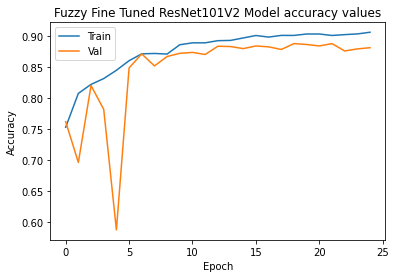

In [ ]:
plt.plot(model_history_fine_resnet.history['accuracy'])
plt.plot(model_history_fine_resnet.history['val_accuracy'])
plt.title('Stacked Fine Tuned ResNet101V2 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

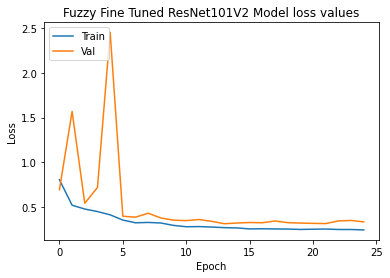

In [ ]:
plt.plot(model_history_fine_resnet.history['loss'])
plt.plot(model_history_fine_resnet.history['val_loss'])
plt.title('Stacked Fine Tuned ResNet101V2 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 4s 29ms/step


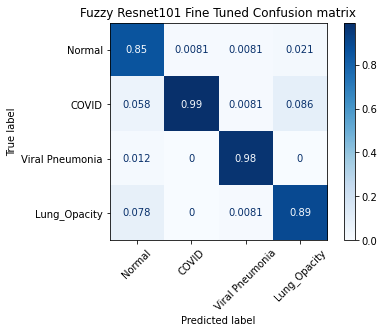

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked Resnet101 Fine Tuned Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fuzzy_resnet_model_2.h5')
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 4s 32ms/step - loss: 0.3074 - accuracy: 0.8868
Test loss: 0.30742159485816956
Test accuracy: 0.8867924809455872


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

         Normal       0.85      0.99      0.91      1020
          COVID       0.99      0.67      0.80       363
Viral Pneumonia       0.98      0.90      0.93       135
   Lung_Opacity       0.89      0.85      0.87       602

       accuracy                           0.89      2120
      macro avg       0.93      0.85      0.88      2120
   weighted avg       0.90      0.89      0.88      2120



In [ ]:
model_history_fine_resnet.history

{'loss': [0.8032949566841125,
  0.5171502232551575,
  0.4741104245185852,
  0.4460337460041046,
  0.40927577018737793,
  0.35071784257888794,
  0.31978029012680054,
  0.3240416944026947,
  0.31752026081085205,
  0.2907049059867859,
  0.2755890190601349,
  0.27747437357902527,
  0.27238088846206665,
  0.26553604006767273,
  0.2623606026172638,
  0.25128600001335144,
  0.2528875470161438,
  0.2509264349937439,
  0.2495443969964981,
  0.24537073075771332,
  0.2479705661535263,
  0.24993297457695007,
  0.24479679763317108,
  0.24462547898292542,
  0.2400604635477066],
 'accuracy': [0.7526284456253052,
  0.8072652220726013,
  0.8217365741729736,
  0.8311281800270081,
  0.8444772362709045,
  0.8599527478218079,
  0.870998203754425,
  0.8715888857841492,
  0.8706438541412354,
  0.8856467604637146,
  0.8887182474136353,
  0.8887182474136353,
  0.8922032117843628,
  0.8926166296005249,
  0.8965741395950317,
  0.9005315899848938,
  0.8979917168617249,
  0.900708794593811,
  0.9006497263908386,
 